In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from modules.Utils.utils import DummyLogger
import sqlite3
from tqdm import tqdm
import time
import subprocess
import matplotlib.dates as mdates
from datetime import datetime
from astropy.table import Table
from tqdm.notebook import tqdm_notebook
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
!pip install seaborn
import seaborn as sns

from matplotlib.ticker import FuncFormatter
def format_thousands(value, tick_number):
    return f'{int(value / 1000)}k'

import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 20})

%matplotlib inline

     |████████████████████████████████| 292 kB 2.5 MB/s            


In [2]:
db_path = 'kpf_ts_oct2024_v3.db' # name of database file
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/kpf_ts_oct2024_v3.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 33057 obs x 1214 cols over 57 days in 20240901-20241027; updated 2025-02-27 03:47:04


In [3]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute(
    """
    SELECT keyword, description
    FROM kpfdb_metadata
    WHERE source = "L2 RV Extension"
    ORDER BY keyword;
    """)
rows = cursor.fetchall()
keywords = [f'"{keyword}"' for keyword, description in rows if keyword]

query = f"""SELECT ObsID, OBJECT, [DATE-MID], NOTJUNK, GOODREAD, CCFBCV, CCFBJD as 'CCFBJD_Avg', BCVRNG, BCVSTD, EXPTIME, GAIAMAG, [2MASSMAG], TARGTEFF, [EMDATE-B], [EMDATE-E], L0_filename,   
    {', '.join(keywords)} 
    FROM kpfdb
    WHERE NOTJUNK = 1.0 AND OBJECT NOT LIKE '%autocal%' AND Source = 'Star'"""
df = pd.read_sql_query(query, conn)
conn.close()
df

,ObsID,OBJECT,DATE-MID,NOTJUNK,GOODREAD,CCFBCV,CCFBJD_Avg,BCVRNG,BCVSTD,EXPTIME,...,RVY57,RVY58,RVY59,RVY60,RVY61,RVY62,RVY63,RVY64,RVY65,RVY66
0,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,1,None,-0.735386,2.460555e+06,NaN,NaN,60.0,...,0.0,73.9994503492939,87.6714544762298,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KP.20240901.25818.06,201092,2024-09-01T07:10:48.073,1,None,-0.738219,2.460555e+06,NaN,NaN,60.0,...,0.0,76.5204767988828,-60.1857207938152,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KP.20240901.25926.46,201092,2024-09-01T07:12:36.475,1,None,-0.741102,2.460555e+06,NaN,NaN,60.0,...,0.0,-8.66980641338825,17.2859798390395,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KP.20240901.26200.94,TIC198162530,2024-09-01T07:21:40.954,1,None,-3.289237,2.460555e+06,NaN,NaN,600.0,...,0.0,-95.7725969275614,-90.7507848517297,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KP.20240901.26961.63,142373,2024-09-01T07:29:51.644,1,None,-12.738138,2.460555e+06,NaN,NaN,60.0,...,0.0,-60.2793117313946,-60.523441115301,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,KP.20241026.49181.48,52711,2024-10-26T13:44:04.989,1,None,28.050886,2.460610e+06,0.096732,0.020964,527.0,...,0.0,22.7169217062974,-38.2785349674322,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4499,KP.20241026.49992.37,HIP37217,2024-10-26T14:04:50.091,1,None,22.411861,2.460610e+06,1.072112,0.269831,1569.0,...,0.0,-1.92022982588995,65.4683625601405,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4500,KP.20241026.51667.01,44219,2024-10-26T14:22:18.551,1,None,21.881098,2.460610e+06,0.127194,0.029238,143.0,...,0.0,-112.696855858522,15.7976897824488,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4501,KP.20241026.52204.35,HAT-P-20,2024-10-26T14:37:01.365,1,None,29.100836,2.460610e+06,2.947692,0.721304,1685.0,...,0.0,30.9935161416225,0.353441354465979,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#identifying columns to reshape (the ones ending with digits)
columns_to_reshape = [col for col in df.columns if col[-2:].isdigit()]

#extracting ORDER and prefix from the column names
order_list = []
prefix_list = []
for col in columns_to_reshape:
    prefix = col[:-2]  # Extract the prefix (e.g., 'BCRV')
    order = col[-2:]   # Extract the order (e.g., '00')
    prefix_list.append(prefix)
    order_list.append(order)

#creating new dataframe with ORDER 
unique_orders = sorted(set(order_list))  # Unique ORDER values
new_df = pd.DataFrame({
    'ORDER': unique_orders,
})

#add preserved columns to the new dataframe
preserved_columns = ['ObsID', 'OBJECT', 'DATE-MID', 'CCFBCV', 'CCFBJD_Avg', 'BCVRNG', 'BCVSTD', 'EXPTIME', 'GAIAMAG', '2MASSMAG', 'TARGTEFF', 'EMDATE-B', 'EMDATE-E', 'L0_filename']
temp_df = df[preserved_columns].assign(key=1)
new_df = new_df.assign(key=1).merge(temp_df, on='key', how='outer').drop('key', axis=1)

#adding columns for each unique prefix
unique_prefixes = set(prefix_list)
for prefix in unique_prefixes:
    new_df[prefix] = None  # Initialize the column with None

#populating the new DataFrame with values from the original DataFrame
for i, col in enumerate(columns_to_reshape):
    prefix = prefix_list[i]
    order = order_list[i]
    new_df.loc[new_df['ORDER'] == order, prefix] = df[col].values

#sorting the DataFrame by preserved columns and ORDER
new_df = new_df.sort_values(by=preserved_columns + ['ORDER']).reset_index(drop=True)

new_df

,ORDER,ObsID,OBJECT,DATE-MID,CCFBCV,CCFBJD_Avg,BCVRNG,BCVSTD,EXPTIME,GAIAMAG,...,RVC,RV3,ERVC,RV2,RVY,CCFBJD,ERVS,RVS,ERVY,BCRV
0,00,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228612,0.00371330351343654,0.0,0.0,-0.735393310978223
1,01,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228201,0.00353493677869039,0.0,0.0,-0.735383983169038
2,02,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228251,0.00271216561490699,0.0,0.0,-0.735385113215487
3,03,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228298,0.00283316785135073,0.0,0.0,-0.735386190340934
4,04,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228258,0.00228852358975969,0.0,0.0,-0.735385270746997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301696,62,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,0.00914154823921011,0.0,0.000475514395909022,0.0,0.0,2460610.12080313,0.0,0.0,0.0,24.1976159080732
301697,63,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,-0.000684368049018988,0.0,0.000440153840225037,0.0,0.0,2460610.12079732,0.0,0.0,0.0,24.1976221527514
301698,64,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,0.0114146858877544,0.0,0.00086853335713448,0.0,0.0,2460610.12079346,0.0,0.0,0.0,24.1976263076159
301699,65,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,-0.00788511566110868,0.0,0.00080678890915096,0.0,0.0,2460610.12079598,0.0,0.0,0.0,24.197623595531


In [5]:
#filtering out zero weights
new_df = new_df.loc[new_df['CCFW'].astype(float) > 0.0].copy()

#BCRV as m/s, CCFBJ as seconds, and with correction
new_df.loc[:, 'BCRV_Corr'] = (new_df['BCRV'].astype(float) * 1000) - (new_df['CCFBCV'].astype(float)*1000)
new_df.loc[:, 'CCFBJ_Corr'] = (new_df['CCFBJD'].astype(float) - new_df['CCFBJD_Avg'].astype(float)) * 86400
new_df['ORDER'] = new_df['ORDER'].astype(str)

In [6]:
#normalizing BCRV_Corr and CCFBJ_Corr with respect to EXPTIME
new_df.loc[:, 'BCRV_Norm'] = new_df['BCRV_Corr'] / new_df['EXPTIME'].astype(float)
new_df.loc[:, 'BJD_Norm'] = new_df['CCFBJ_Corr'] / new_df['EXPTIME'].astype(float)

#setting datatypes
new_df['BCVRNG'] = new_df['BCVRNG'].astype(float)
new_df['GAIAMAG'] = pd.to_numeric(new_df['GAIAMAG'], errors='coerce')
new_df['2MASSMAG'] = pd.to_numeric(new_df['2MASSMAG'], errors='coerce')
new_df['TARGTEFF'] = new_df['TARGTEFF'].astype(float)
new_df['EXPTIME'] = new_df['EXPTIME'].astype(float)

#changing any temperature above 40K to 5770
new_df.loc[new_df['TARGTEFF'] > 40000, 'TARGTEFF'] = 5770

In [7]:
new_df = new_df.sort_values(by=['ORDER'], ascending=True)

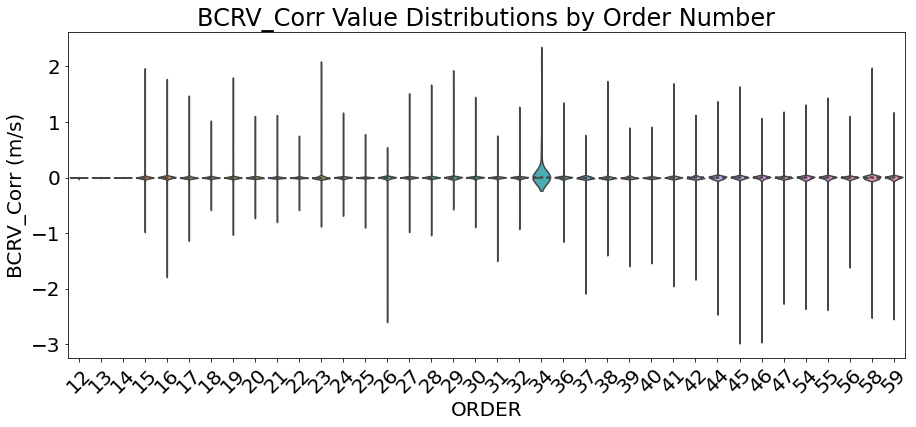

In [8]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 6))
sns.violinplot(x="ORDER", y="BCRV_Corr", data=new_df, scale="width", inner="quartile")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("BCRV_Corr Value Distributions by Order Number")
plt.ylabel('BCRV_Corr (m/s)')
plt.show()

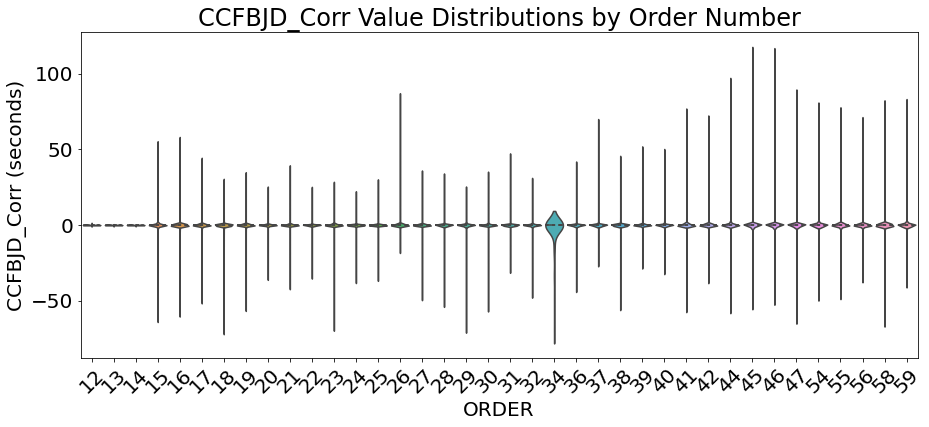

In [9]:
plt.figure(figsize=(15, 6))
sns.violinplot(x="ORDER", y="CCFBJ_Corr", data=new_df, scale="width", inner="quartile")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("CCFBJD_Corr Value Distributions by Order Number")
plt.ylabel('CCFBJD_Corr (seconds)')
plt.show()

In [8]:
BJSortHigh = new_df.sort_values(by='CCFBJ_Corr', ascending=False)
BJSortHigh[['ORDER', 'CCFBJ_Corr', 'L0_filename']].head()

,ORDER,CCFBJ_Corr,L0_filename
273204,45,116.149521,KP.20241016.55598.79.fits
273205,46,115.453126,KP.20241016.55598.79.fits
273203,44,95.759127,KP.20241016.55598.79.fits
273206,47,88.196504,KP.20241016.55598.79.fits
284910,26,85.968031,KP.20241021.32152.40.fits


In [9]:
BJSortLow = new_df.sort_values(by='CCFBJ_Corr', ascending=True)
BJSortLow[['ORDER', 'CCFBJ_Corr', 'L0_filename']].head()

,ORDER,CCFBJ_Corr,L0_filename
41759,18,-70.985050,KP.20240919.23861.94.fits
76275,29,-70.024605,KP.20240925.25892.64.fits
269441,34,-68.961726,KP.20241015.32865.99.fits
284907,23,-68.882386,KP.20241021.32152.40.fits
301625,58,-65.383713,KP.20241026.52204.35.fits


In [10]:
BCVSortHigh = new_df.sort_values(by='BCRV_Corr', ascending=False)
BCVSortHigh[['ORDER', 'BCRV_Corr', 'L0_filename']].head()

,ORDER,BCRV_Corr,L0_filename
269441,34,2.119836,KP.20241015.32865.99.fits
284907,23,2.068891,KP.20241021.32152.40.fits
280611,15,1.941600,KP.20241020.43635.09.fits
301625,58,1.941022,KP.20241026.52204.35.fits
267292,29,1.908048,KP.20241013.33188.96.fits


In [11]:
BCVSortLow = new_df.sort_values(by='BCRV_Corr', ascending=True)
BCVSortLow[['ORDER', 'BCRV_Corr', 'L0_filename']].head()

,ORDER,BCRV_Corr,L0_filename
273204,45,-2.953816,KP.20241016.55598.79.fits
273205,46,-2.936147,KP.20241016.55598.79.fits
284910,26,-2.576222,KP.20241021.32152.40.fits
280655,59,-2.515962,KP.20241020.43635.09.fits
280654,58,-2.489818,KP.20241020.43635.09.fits


In [10]:
#grouping by observation and getting min and max of BCRV_Corr and CCFBJ_Corr
grouped = new_df.groupby('ObsID').agg({
    'BCRV_Corr': [np.min, np.max],
    'BCRV_Norm': [np.min, np.max],
    'CCFBJ_Corr': [np.min, np.max],
    'BJD_Norm': [np.min, np.max],
    'BCVRNG': [np.max],
    'GAIAMAG': [np.max],
    '2MASSMAG': [np.max],
    'TARGTEFF': [np.max],
    'EXPTIME': [np.max]
})
grouped.columns

MultiIndex([( 'BCRV_Corr', 'amin'),
            ( 'BCRV_Corr', 'amax'),
            ( 'BCRV_Norm', 'amin'),
            ( 'BCRV_Norm', 'amax'),
            ('CCFBJ_Corr', 'amin'),
            ('CCFBJ_Corr', 'amax'),
            (  'BJD_Norm', 'amin'),
            (  'BJD_Norm', 'amax'),
            (    'BCVRNG', 'amax'),
            (   'GAIAMAG', 'amax'),
            (  '2MASSMAG', 'amax'),
            (  'TARGTEFF', 'amax'),
            (   'EXPTIME', 'amax')],
           )

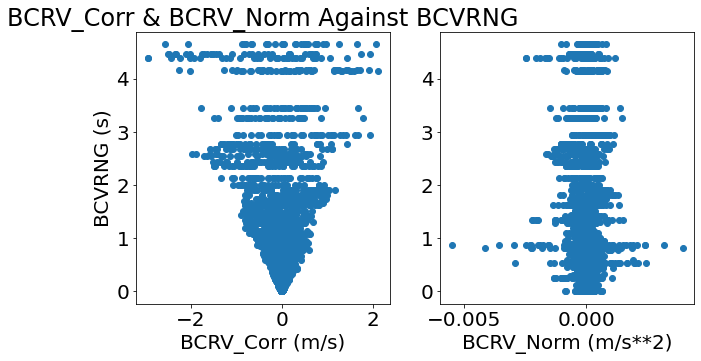

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(new_df['BCRV_Corr'], new_df['BCVRNG'])
axes[0].set_title('BCRV_Corr & BCRV_Norm Against BCVRNG')
axes[0].set_xlabel('BCRV_Corr (m/s)')
axes[0].set_ylabel('BCVRNG (s)')
axes[1].scatter(new_df['BCRV_Norm'], new_df['BCVRNG'])
axes[1].set_xlabel('BCRV_Norm (m/s**2)')
plt.show()

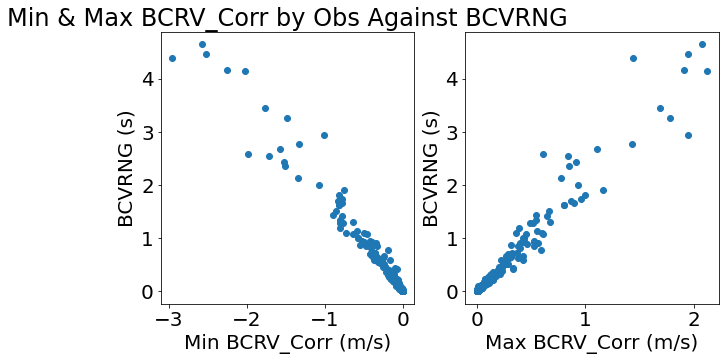

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(grouped[( 'BCRV_Corr', 'amin')], grouped[(    'BCVRNG', 'amax')])
axes[0].set_title('Min & Max BCRV_Corr by Obs Against BCVRNG')
axes[0].set_xlabel('Min BCRV_Corr (m/s)')
axes[0].set_ylabel('BCVRNG (s)')
axes[1].scatter(grouped[( 'BCRV_Corr', 'amax')], grouped[(    'BCVRNG', 'amax')])
axes[1].set_xlabel('Max BCRV_Corr (m/s)')
axes[1].set_ylabel('BCVRNG (s)')
plt.show()

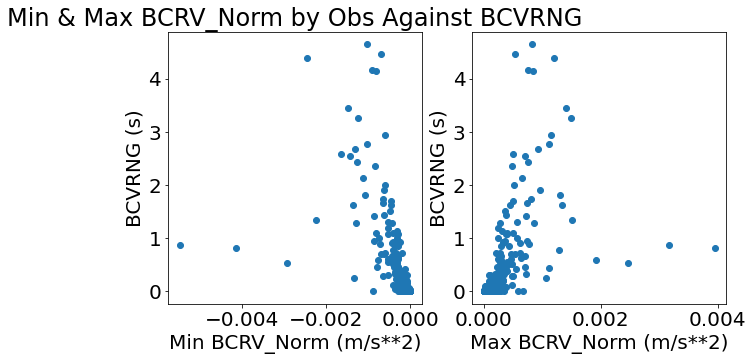

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(grouped[( 'BCRV_Norm', 'amin')], grouped[(    'BCVRNG', 'amax')])
axes[0].set_title('Min & Max BCRV_Norm by Obs Against BCVRNG')
axes[0].set_xlabel('Min BCRV_Norm (m/s**2)')
axes[0].set_ylabel('BCVRNG (s)')
axes[1].scatter(grouped[( 'BCRV_Norm', 'amax')], grouped[(    'BCVRNG', 'amax')])
axes[1].set_xlabel('Max BCRV_Norm (m/s**2)')
axes[1].set_ylabel('BCVRNG (s)')
plt.show()

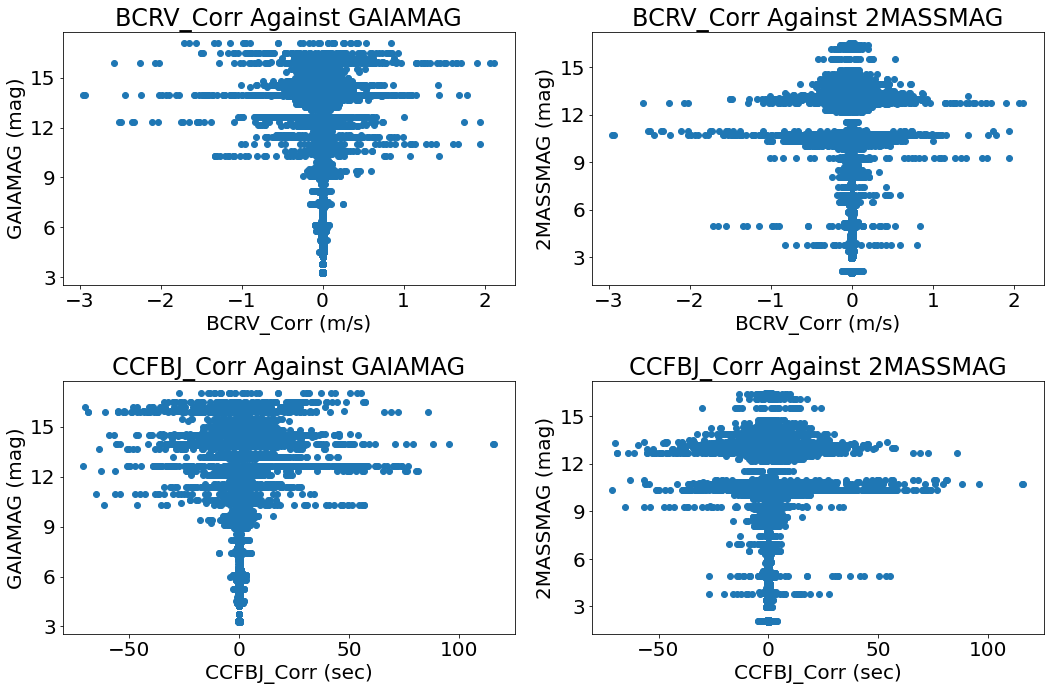

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BCRV_Corr'], new_df['GAIAMAG'])
axes[0][0].set_title('BCRV_Corr Against GAIAMAG')
axes[0][0].set_xlabel('BCRV_Corr (m/s)')
axes[0][0].set_ylabel('GAIAMAG (mag)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BCRV_Corr'], new_df['2MASSMAG'])
axes[0][1].set_title('BCRV_Corr Against 2MASSMAG')
axes[0][1].set_xlabel('BCRV_Corr (m/s)')
axes[0][1].set_ylabel('2MASSMAG (mag)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df['CCFBJ_Corr'], new_df['GAIAMAG'])
axes[1][0].set_title('CCFBJ_Corr Against GAIAMAG')
axes[1][0].set_xlabel('CCFBJ_Corr (sec)')
axes[1][0].set_ylabel('GAIAMAG (mag)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df['CCFBJ_Corr'], new_df['2MASSMAG'])
axes[1][1].set_title('CCFBJ_Corr Against 2MASSMAG')
axes[1][1].set_xlabel('CCFBJ_Corr (sec)')
axes[1][1].set_ylabel('2MASSMAG (mag)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

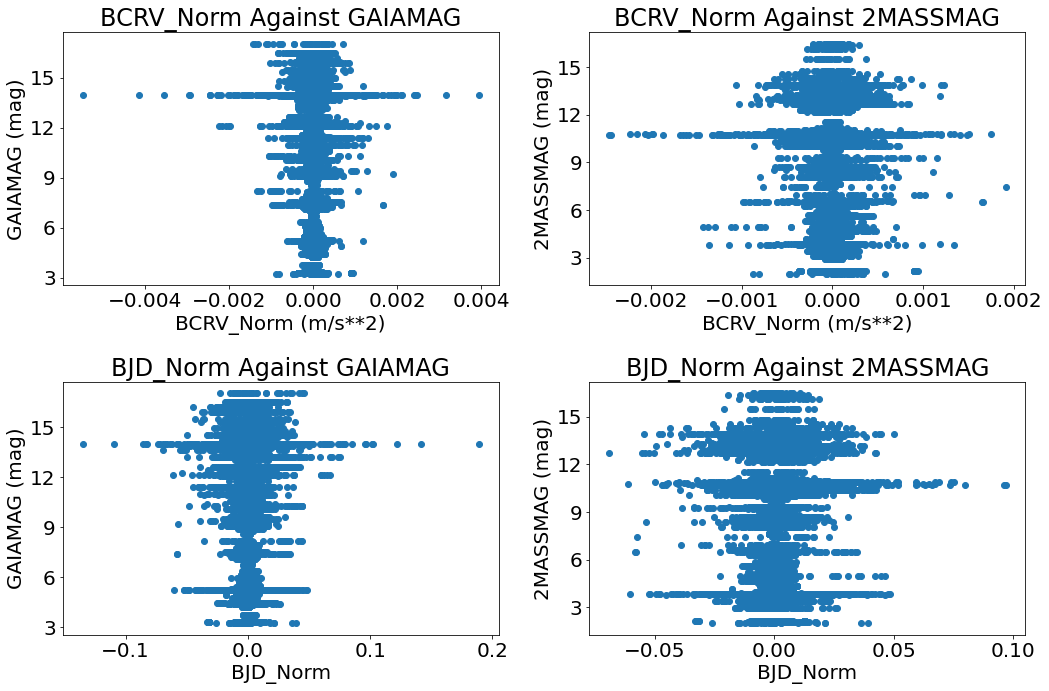

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BCRV_Norm'], new_df['GAIAMAG'])
axes[0][0].set_title('BCRV_Norm Against GAIAMAG')
axes[0][0].set_xlabel('BCRV_Norm (m/s**2)')
axes[0][0].set_ylabel('GAIAMAG (mag)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BCRV_Norm'], new_df['2MASSMAG'])
axes[0][1].set_title('BCRV_Norm Against 2MASSMAG')
axes[0][1].set_xlabel('BCRV_Norm (m/s**2)')
axes[0][1].set_ylabel('2MASSMAG (mag)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df['BJD_Norm'], new_df['GAIAMAG'])
axes[1][0].set_title('BJD_Norm Against GAIAMAG')
axes[1][0].set_xlabel('BJD_Norm')
axes[1][0].set_ylabel('GAIAMAG (mag)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df['BJD_Norm'], new_df['2MASSMAG'])
axes[1][1].set_title('BJD_Norm Against 2MASSMAG')
axes[1][1].set_xlabel('BJD_Norm')
axes[1][1].set_ylabel('2MASSMAG (mag)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

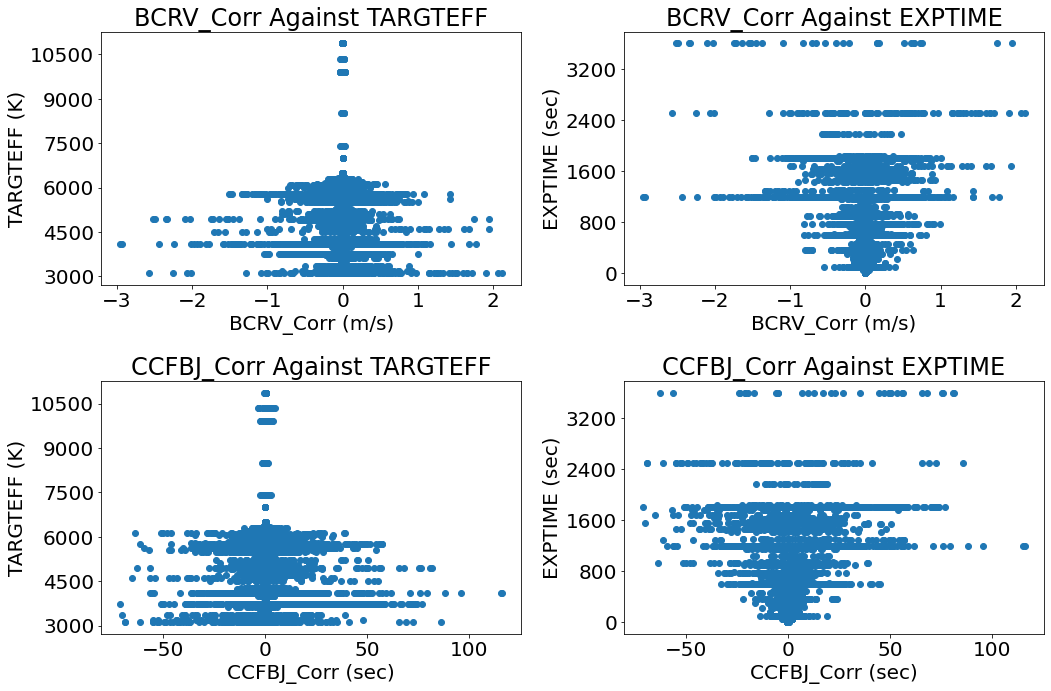

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BCRV_Corr'], new_df['TARGTEFF'])
axes[0][0].set_title('BCRV_Corr Against TARGTEFF')
axes[0][0].set_xlabel('BCRV_Corr (m/s)')
axes[0][0].set_ylabel('TARGTEFF (K)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BCRV_Corr'], new_df['EXPTIME'])
axes[0][1].set_title('BCRV_Corr Against EXPTIME')
axes[0][1].set_xlabel('BCRV_Corr (m/s)')
axes[0][1].set_ylabel('EXPTIME (sec)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df['CCFBJ_Corr'], new_df['TARGTEFF'])
axes[1][0].set_title('CCFBJ_Corr Against TARGTEFF')
axes[1][0].set_xlabel('CCFBJ_Corr (sec)')
axes[1][0].set_ylabel('TARGTEFF (K)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df['CCFBJ_Corr'], new_df['EXPTIME'])
axes[1][1].set_title('CCFBJ_Corr Against EXPTIME')
axes[1][1].set_xlabel('CCFBJ_Corr (sec)')
axes[1][1].set_ylabel('EXPTIME (sec)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

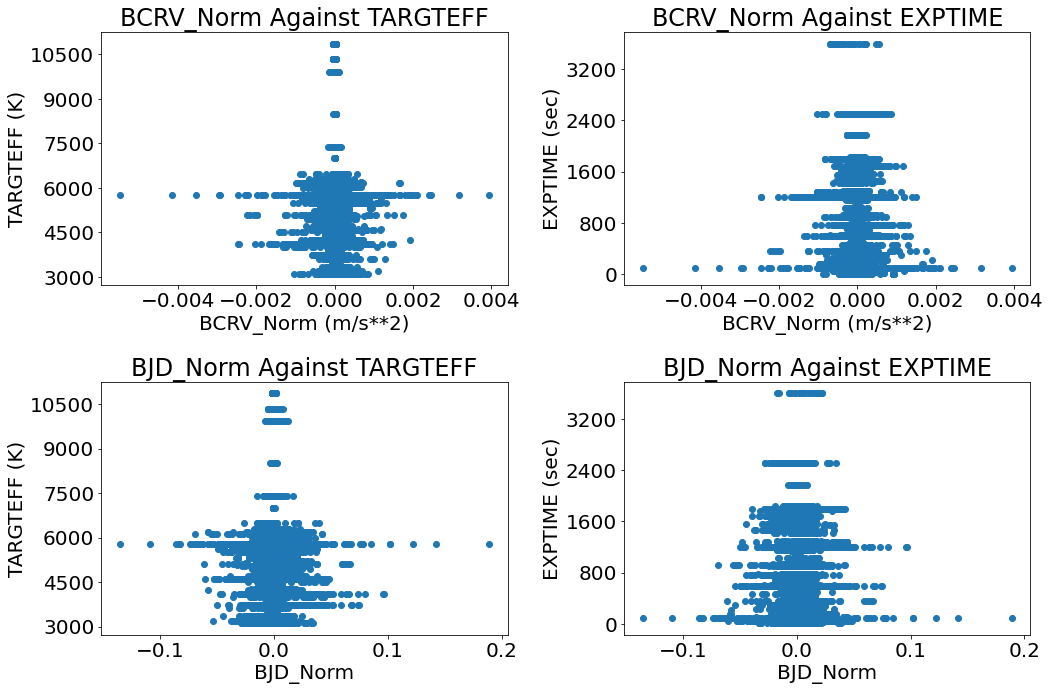

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BCRV_Norm'], new_df['TARGTEFF'])
axes[0][0].set_title('BCRV_Norm Against TARGTEFF')
axes[0][0].set_xlabel('BCRV_Norm (m/s**2)')
axes[0][0].set_ylabel('TARGTEFF (K)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BCRV_Norm'], new_df['EXPTIME'])
axes[0][1].set_title('BCRV_Norm Against EXPTIME')
axes[0][1].set_xlabel('BCRV_Norm (m/s**2)')
axes[0][1].set_ylabel('EXPTIME (sec)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df['BJD_Norm'], new_df['TARGTEFF'])
axes[1][0].set_title('BJD_Norm Against TARGTEFF')
axes[1][0].set_xlabel('BJD_Norm')
axes[1][0].set_ylabel('TARGTEFF (K)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df['BJD_Norm'], new_df['EXPTIME'])
axes[1][1].set_title('BJD_Norm Against EXPTIME')
axes[1][1].set_xlabel('BJD_Norm')
axes[1][1].set_ylabel('EXPTIME (sec)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

In [32]:
TempSortHigh = df.sort_values(by='TARGTEFF', ascending=False)
TempSortHigh[['TARGTEFF', 'L0_filename', 'OBJECT']].head(20)

,TARGTEFF,L0_filename,OBJECT
118,45000.0,KP.20240906.29558.10.fits,HR7950
3922,45000.0,KP.20241012.26432.85.fits,Kepler-1517
3919,45000.0,KP.20241012.24487.13.fits,Kepler-1517
3918,45000.0,KP.20241012.23838.56.fits,Kepler-1517
3917,45000.0,KP.20241012.23189.84.fits,Kepler-1517
3916,45000.0,KP.20241012.22541.21.fits,Kepler-1517
4499,45000.0,KP.20241026.49992.37.fits,HIP37217
3915,45000.0,KP.20241012.21892.54.fits,Kepler-1517
3914,45000.0,KP.20241012.21243.92.fits,Kepler-1517
128,45000.0,KP.20240906.29928.98.fits,HR7950


In [34]:
# corr_BCRV = new_df[['BCRV_Corr', 'GAIAMAG', '2MASSMAG', 'TARGTEFF', 'EXPTIME']]
# sns.pairplot(corr_BCRV)
# plt.show()

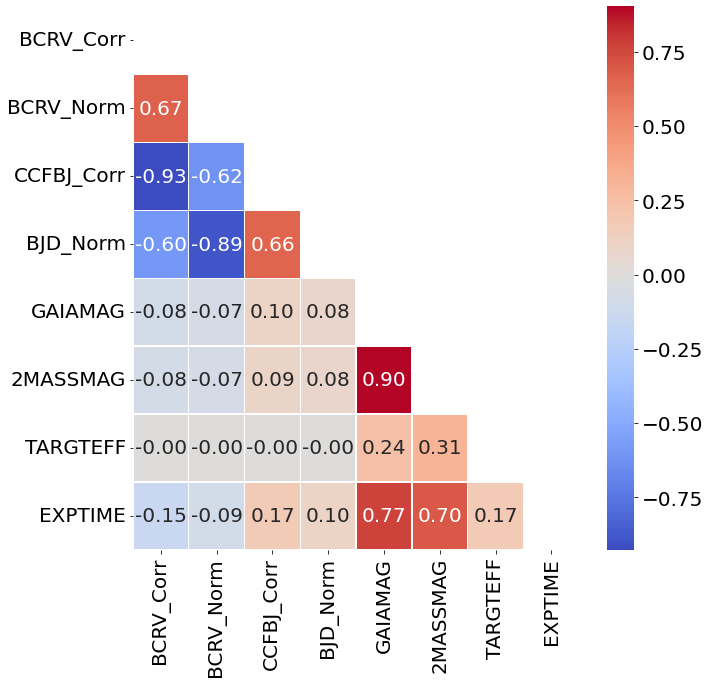

In [26]:
selected_columns = ['BCRV_Corr', 'BCRV_Norm', 'CCFBJ_Corr', 'BJD_Norm', 'GAIAMAG', '2MASSMAG', 'TARGTEFF', 'EXPTIME']
corr_matrix = new_df[selected_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=90)

plt.show()

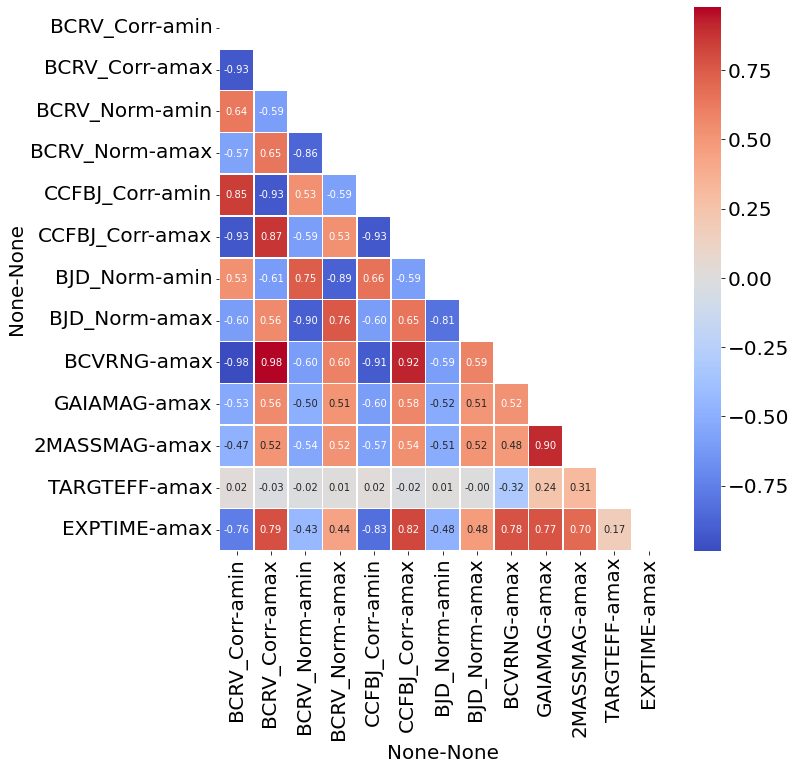

In [29]:
corr_matrix = grouped.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,  annot_kws={"size": 10})
plt.xticks(rotation=90)

plt.show()

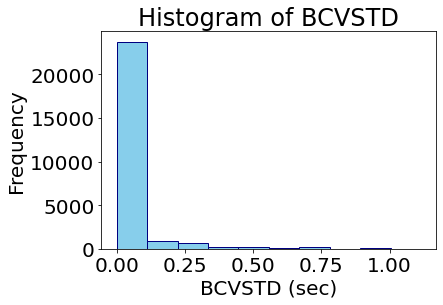

In [14]:
plt.hist(new_df['BCVSTD'], bins=10, color='skyblue', edgecolor='navy')
plt.title('Histogram of BCVSTD')
plt.xlabel("BCVSTD (sec)")
plt.ylabel("Frequency")
plt.show()

In [15]:
new_df.loc[:, 'EMDATE_ns'] = (pd.to_datetime(new_df['EMDATE-E']) - pd.to_datetime(new_df['EMDATE-B']))
new_df.loc[:, 'EMDATE'] = new_df['EMDATE_ns'].dt.total_seconds()

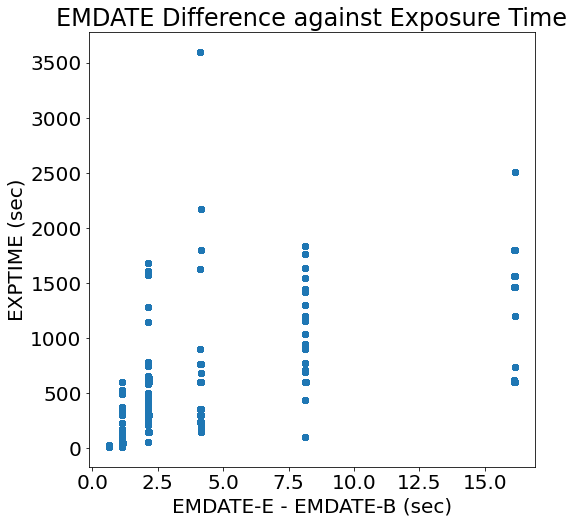

In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(new_df['EMDATE'], new_df['EXPTIME'])
plt.title("EMDATE Difference against Exposure Time")
plt.xlabel("EMDATE-E - EMDATE-B (sec)")
plt.ylabel("EXPTIME (sec)")
plt.show()

In [16]:
myTS.print_metadata_table()

Derived Keywords:
------------------------------------------------------------------------------------------
Keyword                             Datatype  Units     Description                                                                               
------------------------------------------------------------------------------------------
D2_filename                         string    None      Full path to 2D file                                                                      
D2_header_read_time                 string    None      Last modification of 2D file                                                              
L0_filename                         string    None      Full path to L0 file                                                                      
L0_header_read_time                 string    None      Last modification of L0 file                                                              
L1_filename                         string    None      Full path

In [30]:
BJSortHigh = new_df.sort_values(by='CCFBJ_Corr', ascending=False)
BJSortHigh[['ORDER', 'CCFBJ_Corr', 'BJD_Norm', 'BCRV_Corr', 'BCRV_Norm', 'L0_filename']].head()

,ORDER,CCFBJ_Corr,BJD_Norm,BCRV_Corr,BCRV_Norm,L0_filename
273204,45,116.149521,0.096791,-2.953816,-0.002462,KP.20241016.55598.79.fits
273205,46,115.453126,0.096211,-2.936147,-0.002447,KP.20241016.55598.79.fits
273203,44,95.759127,0.079799,-2.436701,-0.002031,KP.20241016.55598.79.fits
273206,47,88.196504,0.073497,-2.244772,-0.001871,KP.20241016.55598.79.fits
284910,26,85.968031,0.034332,-2.576222,-0.001029,KP.20241021.32152.40.fits


In [31]:
BJSortHigh = new_df.sort_values(by='BJD_Norm', ascending=False)
BJSortHigh[['ORDER', 'CCFBJ_Corr', 'BJD_Norm', 'BCRV_Corr', 'BCRV_Norm', 'L0_filename']].head()

,ORDER,CCFBJ_Corr,BJD_Norm,BCRV_Corr,BCRV_Norm,L0_filename
272317,29,18.902694,0.189027,-0.548081,-0.005481,KP.20241016.40022.15.fits
272379,24,14.200889,0.142009,-0.414122,-0.004141,KP.20241016.40207.65.fits
272316,28,12.217033,0.122170,-0.354189,-0.003542,KP.20241016.40022.15.fits
272335,47,10.208233,0.102082,-0.295929,-0.002959,KP.20241016.40022.15.fits
272240,19,10.189766,0.101898,-0.292621,-0.002926,KP.20241016.39726.33.fits


In [32]:
BCRVSortHigh = new_df.sort_values(by='BCRV_Corr', ascending=False)
BCRVSortHigh[['ORDER', 'CCFBJ_Corr', 'BJD_Norm', 'BCRV_Corr', 'BCRV_Norm', 'L0_filename']].head()

,ORDER,CCFBJ_Corr,BJD_Norm,BCRV_Corr,BCRV_Norm,L0_filename
269441,34,-68.961726,-0.027541,2.119836,0.000847,KP.20241015.32865.99.fits
284907,23,-68.882386,-0.027509,2.068891,0.000826,KP.20241021.32152.40.fits
280611,15,-62.819615,-0.017450,1.941600,0.000539,KP.20241020.43635.09.fits
301625,58,-65.383713,-0.038803,1.941022,0.001152,KP.20241026.52204.35.fits
267292,29,-61.303027,-0.024482,1.908048,0.000762,KP.20241013.33188.96.fits


In [34]:
BCRVSortHigh = new_df.sort_values(by='BCRV_Norm', ascending=False)
BCRVSortHigh[['ORDER', 'CCFBJ_Corr', 'BJD_Norm', 'BCRV_Corr', 'BCRV_Norm', 'L0_filename', 'EXPTIME']].head()

,ORDER,CCFBJ_Corr,BJD_Norm,BCRV_Corr,BCRV_Norm,L0_filename,EXPTIME
120975,40,0.0,NaN,5.456968e-12,inf,KP.20240927.16400.95.fits,0.0
121020,18,0.0,NaN,5.456968e-12,inf,KP.20240927.16433.94.fits,0.0
121058,56,0.0,NaN,5.456968e-12,inf,KP.20240927.16433.94.fits,0.0
121022,20,0.0,NaN,5.456968e-12,inf,KP.20240927.16433.94.fits,0.0
120965,30,0.0,NaN,5.456968e-12,inf,KP.20240927.16400.95.fits,0.0
